In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product
import re       

In [12]:
dataset = 'hybrid_tibialis'
bids_root = str(Path.home()) + '/Documents/muniverse-data/report_cards/'
pipeline = 'cbss'
path = bids_root + dataset + '-' + pipeline + '/' + 'hybrid-tibialis' + '-' + pipeline + '_'


df1 = pd.read_csv(path + 'report_card_globals_0_20.tsv', delimiter='\t')
df2 = pd.read_csv(path + 'report_card_globals_20_40.tsv', delimiter='\t')
df3 = pd.read_csv(path + 'report_card_globals_40_60.tsv', delimiter='\t')
df4 = pd.read_csv(path + 'report_card_globals_60_80.tsv', delimiter='\t')
df5 = pd.read_csv(path + 'report_card_globals_80_100.tsv', delimiter='\t')
df = pd.concat([df1, df2, df4, df5], ignore_index=True)
path = bids_root + dataset + '-' + pipeline + '/'
df.to_csv(path + 'report_card_globals.tsv', sep='\t', index=False)

path = bids_root + dataset + '-' + pipeline + '/' + 'hybrid-tibialis' + '-' + pipeline + '_'
df1 = pd.read_csv(path + 'report_card_sources_0_20.tsv', delimiter='\t')
df2 = pd.read_csv(path + 'report_card_sources_20_40.tsv', delimiter='\t')
df3 = pd.read_csv(path + 'report_card_sources_40_60.tsv', delimiter='\t')
df4 = pd.read_csv(path + 'report_card_sources_60_80.tsv', delimiter='\t')
df5 = pd.read_csv(path + 'report_card_sources_80_100.tsv', delimiter='\t')
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
path = bids_root + dataset + '-' + pipeline + '/'
df.to_csv(path + 'report_card_sources.tsv', sep='\t', index=False)

In [4]:
"""
Make a helper function that extracts the n-th number from a string
"""
def extract_nth_number(s, n):
    numbers = re.findall(r'\d+', s)
    if 0 < n <= len(numbers):
        return int(numbers[n - 1])
    else:
        return None

In [13]:
""" 
Import all report cards

"""

# Path to the report cards
bids_root = str(Path.home()) + '/Documents/muniverse-data/report_cards/'

# List of datasetnames
datasetnames = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'Avrillon_et_al_2024', 'hybrid_tibialis', 'neuromotion_test']
datasetnames = ['hybrid_tibialis']

# List of algorithm names
pipelinenames = ['cbss', 'scd']
pipelinenames = ['cbss', 'upperbound']
pipelinenames = ['cbss', 'scd', 'upperbound']

# Make an empty template of a report card dictonary
global_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}
source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

# Read in report cards
for dataset in datasetnames:
    for pipeline in pipelinenames:
        path = bids_root + dataset + '-' + pipeline + '/'
        dataset_global_rc = pd.read_csv(path + 'report_card_globals.tsv', delimiter='\t')
        dataset_source_rc = pd.read_csv(path + 'report_card_sources.tsv', delimiter='\t')
        global_rc[pipeline] = pd.concat([global_rc[pipeline], dataset_global_rc], ignore_index=True)
        source_rc[pipeline] = pd.concat([source_rc[pipeline], dataset_source_rc], ignore_index=True)

In [14]:
""" 
Extract some global metrics from some dataset of interest

"""

#dataset_of_interest = ['neuromotion-test']
dataset_of_interest = ['hybrid-tibialis']
#dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'Avrillon_et_al_2024']
#dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025', 'hybrid-tibialis', 'neuromotion-test']

#task_keys = ['isometric', 'trapezoid']
task_keys = []

rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source_10', 'n_source_50', 'n_source_90', 
           'exp_var_10', 'exp_var_50', 'exp_var_90',
           'runtime_10', 'runtime_50', 'runtime_90']
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

sil_th = 0.87
min_num_spikes = 30
mvc_threshold = 100

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        # Get a unqiue identifier, i.e., dataset-pipeline
        row = f"{dataset}-{pipeline}"
        
        # Make a copy of the global data frame
        gdf = global_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        gdf = gdf[(gdf['datasetname'] == dataset)]
        # Make sure the explained variance is in [0 1]
        gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            gdf = gdf[gdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        if dataset=='neuromotion-test':
            mvc_num = 3
        else:
            mvc_num = 2
        gdf['mvc'] = gdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        gdf = gdf[(gdf['mvc'] < mvc_threshold)]
        
        # Make a copy of the source report card
        sdf = source_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        sdf = sdf[(sdf['datasetname'] == dataset)]
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            sdf = sdf[sdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        sdf['mvc'] = sdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        sdf = sdf[(sdf['mvc'] < mvc_threshold)]

        # List all filenames that are left to analyze and loop around them   
        files = list(gdf['filename'])
        n_sources = np.zeros(len(files))
        for idx, file in enumerate(files):
            # Make a copy of your source datafile 
            ssdf = sdf.copy()
            # Only keep sources that belong to the current file and fullfile some quality checks
            ssdf = sdf[(sdf['filename'] == file) & 
                       (sdf['sil'] > sil_th) & 
                       (sdf['n_spikes'] > min_num_spikes)]
            n_sources[idx] = ssdf.shape[0]

        # Get the 10th, 50th and 90th percentile of the number of extracted sources
        summary.loc[row, 'n_source_50'] = np.round(np.percentile(n_sources,50) ,2)
        summary.loc[row, 'n_source_10'] = np.round(np.percentile(n_sources,10), 2)
        summary.loc[row, 'n_source_90'] = np.round(np.percentile(n_sources,90), 2)   
        # Get the 10th, 50th and 90th percentile of the runtimes
        summary.loc[row, 'runtime_50'] = np.round(np.percentile(gdf['runtime'],50), 0)
        summary.loc[row, 'runtime_10'] = np.round(np.percentile(gdf['runtime'],10), 0)
        summary.loc[row, 'runtime_90'] = np.round(np.percentile(gdf['runtime'],90), 0)
        # Get the 10th, 50th and 90th percentile of the explained variance
        summary.loc[row, 'exp_var_50'] = np.round(np.percentile(gdf['explained_var'],50), 2)
        summary.loc[row, 'exp_var_10'] = np.round(np.percentile(gdf['explained_var'],10), 2)
        summary.loc[row, 'exp_var_90'] = np.round(np.percentile(gdf['explained_var'],90), 2) 

print(summary)          


                            n_source_10  n_source_50  n_source_90  exp_var_10  \
hybrid-tibialis-cbss               23.0         33.0         48.3        0.00   
hybrid-tibialis-scd                14.7         38.0         69.6        0.02   
hybrid-tibialis-upperbound         30.0         52.0         84.0        0.00   

                            exp_var_50  exp_var_90  runtime_10  runtime_50  \
hybrid-tibialis-cbss              0.67        0.87       286.0       367.0   
hybrid-tibialis-scd               0.70        0.91       270.0       614.0   
hybrid-tibialis-upperbound        0.64        0.86       160.0       191.0   

                            runtime_90  
hybrid-tibialis-cbss             605.0  
hybrid-tibialis-scd              946.0  
hybrid-tibialis-upperbound       247.0  


In [15]:
"""
Do spike matching for some dataset of interest

"""

# Dataset of interest
#dataset_of_interest = ['Grison_et_al_2025']
#dataset_of_interest = ['neuromotion-test']
dataset_of_interest = ['hybrid-tibialis']
# Pipelines to be analyzed
pipelinenames = ['cbss', 'scd']
pipelinenames = ['cbss', 'scd','upperbound']

filt_source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

# Make an empty data frame
rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source', 'n_rel', 
           'roa_10', 'roa_50', 'roa_90', 
           'precision_10', 'precision_50', 'precision_90',
           'sensitivity_10', 'sensitivity_50', 'sensitivity_90',
           'F1_10', 'F1_50', 'F1_90' 
           ]
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

# Select specific tasks
task_keys = []
#task_keys = ['isometric', 'trapezoid']
# Filter by mvc level
mvc_threshold = 100
sil_th = 0.85
match_th = 0.3

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        # Get a unqiue identifier, i.e., dataset-pipeline
        row = f"{dataset}-{pipeline}"
        
        # Make a copy of the global data frame
        gdf = global_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        gdf = gdf[(gdf['datasetname'] == dataset)]
        # Make sure the explained variance is in [0 1]
        gdf['explained_var'] = gdf['explained_var'].clip(lower=0, upper=1)
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            gdf = gdf[gdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        if dataset=='neuromotion-test':
            mvc_num = 3
        else:
            mvc_num = 2
        gdf['mvc'] = gdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        gdf = gdf[(gdf['mvc'] < mvc_threshold)]

        # Make a copy of the source report card
        sdf = source_rc[pipeline].copy()
        # Only keep entries belonging to the current dataset
        sdf = sdf[(sdf['datasetname'] == dataset)]
        # Focus on specific tasks and mvc level
        for task_key in task_keys:
            sdf = sdf[sdf['filename'].str.contains(task_key, case=False, na=False)]
        # Extract the MVC level from the file name and filter by intensity
        sdf['mvc'] = sdf['filename'].apply(lambda x: extract_nth_number(x, mvc_num))    
        sdf = sdf[(sdf['mvc'] < mvc_threshold)]
        # Only keep sources that belong to the current file and fullfile some quality checks
        sdf = sdf[(sdf['sil'] > sil_th)]
        
        # Get the total number of sources
        n_total = int(sdf.shape[0])
        # Get the number of matched sources
        sdf = sdf[(sdf['TP'] > 1)]
        # Compute the rate of agreement
        sdf['RoA'] = sdf['TP'] / (sdf['TP'] + sdf['FP'] + sdf['FN'])
        # Compute the precision
        sdf['Precision'] = sdf['TP'] / (sdf['TP'] + sdf['FP'])
        # Compute the recall
        sdf['Recall'] = sdf['TP'] / (sdf['TP'] + sdf['FN'])
        # Calculate the F1 score
        sdf['F1'] = 2*sdf['Precision']*sdf['Recall']/ (sdf['Precision'] + sdf['Recall'])

        sdf = sdf[(sdf['Recall']>match_th)]

        filt_source_rc[pipeline] = sdf

        # Get both total and relative number of matched sources
        summary.loc[row, 'n_source'] = int(sdf.shape[0])
        if n_total > 0:
            summary.loc[row, 'n_rel'] = int(sdf.shape[0]) / n_total 
        else:
            summary.loc[row, 'n_rel'] = 0
        # Get the 10th, 50th and 90th percentile of the RoA
        summary.loc[row, 'roa_10'] = np.round(np.percentile(sdf['RoA'],10),2)
        summary.loc[row, 'roa_50'] = np.round(np.percentile(sdf['RoA'],50),2)
        summary.loc[row, 'roa_90'] = np.round(np.percentile(sdf['RoA'],90),2)
        # Get the 10th, 50th and 90th percentile of the Precision
        summary.loc[row, 'precision_10'] = np.round(np.percentile(sdf['Precision'],10),2)
        summary.loc[row, 'precision_50'] = np.round(np.percentile(sdf['Precision'],50),2)
        summary.loc[row, 'precision_90'] = np.round(np.percentile(sdf['Precision'],90),2)
        # Get the 10th, 50th and 90th percentile of the Recall
        summary.loc[row, 'sensitivity_10'] = np.round(np.percentile(sdf['Recall'],10),2)
        summary.loc[row, 'sensitivity_50'] = np.round(np.percentile(sdf['Recall'],50),2)
        summary.loc[row, 'sensitivity_90'] = np.round(np.percentile(sdf['Recall'],90),2)
        # Get the 10th, 50th and 90th percentile of the F1 score
        summary.loc[row, 'F1_10'] = np.round(np.percentile(sdf['F1'], 10),2)
        summary.loc[row, 'F1_50'] = np.round(np.percentile(sdf['F1'], 50),2)
        summary.loc[row, 'F1_90'] = np.round(np.percentile(sdf['F1'], 90),2) 



print(summary)          


                            n_source     n_rel  roa_10  roa_50  roa_90  \
hybrid-tibialis-cbss          3732.0  0.976452    0.65    0.92     1.0   
hybrid-tibialis-scd           3776.0  0.985386    0.93    1.00     1.0   
hybrid-tibialis-upperbound    3858.0  0.667590    0.90    0.98     1.0   

                            precision_10  precision_50  precision_90  \
hybrid-tibialis-cbss                0.94           1.0           1.0   
hybrid-tibialis-scd                 1.00           1.0           1.0   
hybrid-tibialis-upperbound          0.98           1.0           1.0   

                            sensitivity_10  sensitivity_50  sensitivity_90  \
hybrid-tibialis-cbss                  0.69            0.93             1.0   
hybrid-tibialis-scd                   0.93            1.00             1.0   
hybrid-tibialis-upperbound            0.92            0.98             1.0   

                            F1_10  F1_50  F1_90  
hybrid-tibialis-cbss         0.79   0.96    1.0  
h

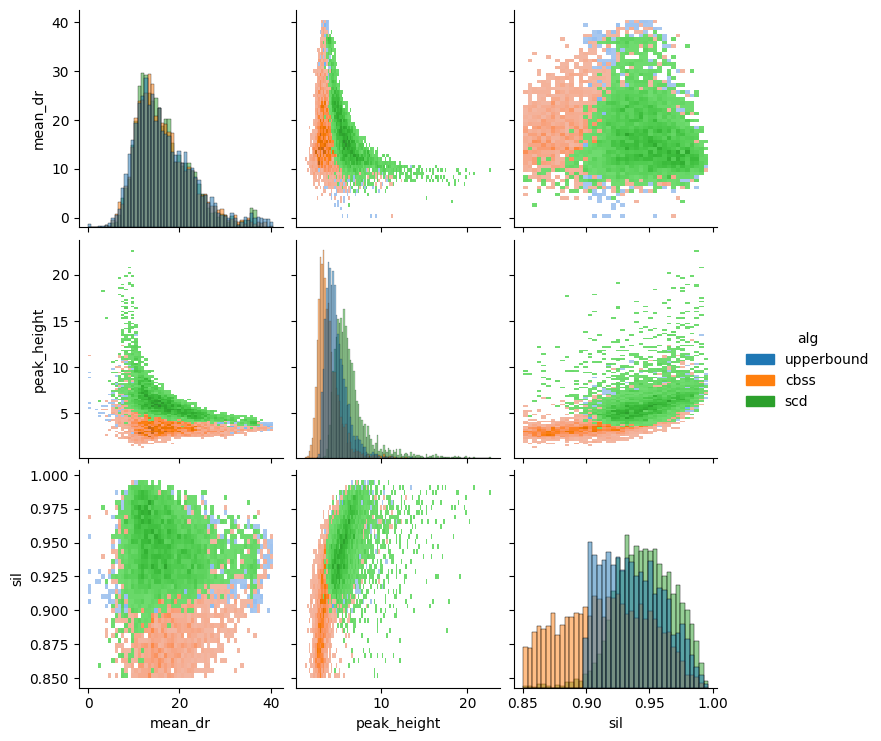

In [ ]:
import seaborn as sns

sdf1 = filt_source_rc['upperbound']
sdf1['alg'] = 'upperbound'
x1 = np.asarray(sdf1['peak_height'])
y1 = np.asarray(sdf1['mean_dr'])

sdf2 = filt_source_rc['cbss']
sdf2['alg'] = 'cbss'
x2 = np.asarray(sdf2['peak_height'])
y2 = np.asarray(sdf2['mean_dr'])

sdf3 = filt_source_rc['scd']
sdf3['alg'] = 'scd'
x3 = np.asarray(sdf3['peak_height'])
y3 = np.asarray(sdf3['mean_dr'])

df = pd.concat([sdf1, sdf2, sdf3], ignore_index=True)

sns.pairplot(df, kind='hist' ,hue='alg', vars=['mean_dr', 'peak_height', 'sil', 'unit_id_ref'])

# # Create a JointGrid
# g = sns.JointGrid(x=x1, y=y1)

# # Plot first dataset
# g.plot_joint(sns.scatterplot, color="blue", label="ub",s=30, alpha=0.4)
# sns.histplot(x=x1, color="blue", ax=g.ax_marg_x, alpha=0.8, bins=np.linspace(0,40,31))
# sns.histplot(y=y1, color="blue", ax=g.ax_marg_y, alpha=0.8, bins=np.linspace(5,45,31))

# # Overlay third dataset
# sns.scatterplot(x=x3, y=y3, color="green", ax=g.ax_joint, label="scd", s=20, alpha=0.2)
# sns.histplot(x=x3, color="green", ax=g.ax_marg_x, alpha=0.6, bins=np.linspace(0,40,31))
# sns.histplot(y=y3, color="green", ax=g.ax_marg_y, alpha=0.6, bins=np.linspace(5,45,31))

# # Overlay second dataset
# sns.scatterplot(x=x2, y=y2, color="red", ax=g.ax_joint, label="cbss", s=10, alpha=0.4)
# sns.histplot(x=x2, color="red", ax=g.ax_marg_x, alpha=0.4, bins=np.linspace(0,40,31))
# sns.histplot(y=y2, color="red", ax=g.ax_marg_y, alpha=0.4, bins=np.linspace(5,45,31))



# # Add legend
# g.ax_joint.legend()
# g.ax_joint.set_xlim(0,40)
# g.ax_joint.set_xlabel("Expected Peak hight")
# g.ax_joint.set_ylabel("Mean firing rate (Hz)")

# plt.show()




